In [4]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset , random_split , ConcatDataset
import matplotlib.pyplot as plt 
import matplotlib_inline.backend_inline

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
from PIL import Image
import os
import imutils
import torch.optim as optim
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')



In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
IMG_PATH_yes = '/home/pratham/Pratham/Brain Cancer detection/brain_tumor_dataset'
IMG_PATH_no = '/home/pratham/Pratham/Brain Cancer detection/brain_tumor_dataset'
# IMG_PATH_yes = os.path.join(IMG_PATH, 'yes')
# IMG_PATH_no = os.path.join(IMG_PATH, 'no')




if not os.path.exists(IMG_PATH_yes):
    raise FileNotFoundError(f"Dataset directory not found: {IMG_PATH_yes}")
TRAIN_DIR = 'TRAIN/'
VAL_DIR = 'VAL/'
TEST_DIR = 'TEST/'
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(split_dir, exist_ok=True)

print(IMG_PATH_yes)


/home/pratham/Pratham/Brain Cancer detection/brain_tumor_dataset


In [53]:

transform = T.Compose([T.Resize((128, 128)),T.ToTensor(), T.Normalize([.5],[.5])])

dataset_yes = datasets.ImageFolder(root= IMG_PATH_yes , transform = transform)
dataset_no = datasets.ImageFolder(root= IMG_PATH_no, transform=transform)

combined_dataset = ConcatDataset([dataset_yes, dataset_no])
total_size = len(combined_dataset)
test_size = int(0.1*total_size)
val_size = int(0.2*total_size)
train_size = total_size - val_size - test_size

train_set, val_set, test_set = random_split(combined_dataset, [train_size, val_size, test_size])



batchsize = 32 

train_loader = DataLoader(train_set,batch_size=batchsize, shuffle=True , drop_last=True)
test_loader = DataLoader(test_set,batch_size=batchsize)
val_loader = DataLoader(val_set,batch_size=batchsize)

print(f"Number of training samples: {len(train_set)}")
print(len(train_set))
print(len(test_set))
print(len(val_set))


Number of training samples: 355
355
50
101


In [12]:

X,y = next(iter(train_loader))
print( X.data.shape)

NameError: name 'train_loader' is not defined

In [14]:
def crop_images(dataset, add_pixels_values=0):
    cropped_images = []
    labels = []
    for item in dataset:
        img, label = item  # Unpack the tuple

        # Convert PyTorch tensor to numpy array
        img_np = img.numpy()
        
        # Move the channel dimension to the end and denormalize
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = (img_np * 0.5 + 0.5) * 255
        img_np = img_np.astype(np.uint8)

        # Your existing image processing code here
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(cnts) > 0:
            c = max(cnts, key=cv2.contourArea)
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])
            
            ADD_PIXELS = add_pixels_values
            new_img = img_np[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, 
                             extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        else:
            new_img = img_np.copy()

        # Convert back to PyTorch tensor
        cropped_img = torch.from_numpy(np.transpose(new_img, (2, 0, 1))).float() / 255.0
        
        # Normalize again to match your original transform
        cropped_img = (cropped_img - 0.5) / 0.5

        cropped_images.append(cropped_img)
        labels.append(label)
    # print(f"Cropped Images Count: {len(cropped_images)}")
    # print(f"Labels Count: {len(labels)}")
    return cropped_images, labels

# Usage
X_train_crop, y_train = crop_images(train_set)
X_val_crop, y_val = crop_images(val_set)
X_test_crop, y_test = crop_images(test_set)
# print(f"Labels in cropped images: {labels}")



NameError: name 'train_set' is not defined

check with claude for yes dataset


In [15]:
def save_new_images(x_set, y_set, folder_name):
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        # Print the label and index for debugging
        print(f"Saving image {i} with label {imclass}")
        
        # Convert PyTorch tensor to numpy array
        img_np = img.numpy()
        
        # Move channels to the end and denormalize
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = (img_np * 0.5 + 0.5) * 255
        img_np = img_np.astype(np.uint8)
        
        # Convert from RGB to BGR (OpenCV uses BGR)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

       
        if imclass == 0:
            cv2.imwrite(os.path.join(folder_name, 'NO', f'{i}.jpg'), img_np)
            print(f"Saved image {i} to {folder_name}/NO/{i}.jpg")
        elif imclass == 1:
            cv2.imwrite(os.path.join(folder_name, 'YES', f'{i}.jpg'), img_np)
            print(f"Saved image {i} to {folder_name}/YES/{i}.jpg")
        else:
            print(f"Unexpected class label {imclass} for image {i}")



        # # Ensure directory exists
        # label_dir_path = os.path.join(folder_name, label_dir)
        # os.makedirs(label_dir_path, exist_ok=True)
        
        # # Save the image
        # img_path = os.path.join(label_dir_path, f'{i}.jpg')
        # cv2.imwrite(img_path, img_np)
        # print(f"Saved image {i} to {img_path}")


# Usage
os.makedirs('TRAIN_CROP/YES', exist_ok=True)
os.makedirs('TRAIN_CROP/NO', exist_ok=True)
os.makedirs('VAL_CROP/YES', exist_ok=True)
os.makedirs('VAL_CROP/NO', exist_ok=True)
os.makedirs('TEST_CROP/YES', exist_ok=True)
os.makedirs('TEST_CROP/NO', exist_ok=True)

save_new_images(X_train_crop, y_train, 'TRAIN_CROP/')
save_new_images(X_val_crop, y_val, 'VAL_CROP/')
save_new_images(X_test_crop, y_test, 'TEST_CROP/')

NameError: name 'X_train_crop' is not defined

In [26]:
def save_new_images(x_set, y_set, folder_name):
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        # Convert PyTorch tensor to numpy array
        img_np = img.numpy()
        
        # Move channels to the end and denormalize
        img_np = np.transpose(img_np, (1, 2, 0))
        img_np = (img_np * 0.5 + 0.5) * 255
        img_np = img_np.astype(np.uint8)
        
        # Convert from RGB to BGR (OpenCV uses BGR)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        
        # Print the label and check the condition
        print(f"Saving image {i} with label {imclass}")

        if imclass == 0:
            print(f"Label is 0, saving to NO folder.")
            cv2.imwrite(os.path.join(folder_name, 'NO', f'{i}.jpg'), img_np)
        elif imclass == 1:
            print(f"Label is 1, saving to YES folder.")
            cv2.imwrite(os.path.join(folder_name, 'YES', f'{i}.jpg'), img_np)
        else:
            print(f"Unexpected class label {imclass} for image {i}")

# Usage
os.makedirs('TRAIN_CROP/YES', exist_ok=True)
os.makedirs('TRAIN_CROP/NO', exist_ok=True)
os.makedirs('VAL_CROP/YES', exist_ok=True)
os.makedirs('VAL_CROP/NO', exist_ok=True)
os.makedirs('TEST_CROP/YES', exist_ok=True)
os.makedirs('TEST_CROP/NO', exist_ok=True)

save_new_images(X_train_crop, y_train, 'TRAIN_CROP/')
save_new_images(X_val_crop, y_val, 'VAL_CROP/')
save_new_images(X_test_crop, y_test, 'TEST_CROP/')

Saving image 0 with label 1
Label is 1, saving to YES folder.
Saving image 1 with label 1
Label is 1, saving to YES folder.
Saving image 2 with label 1
Label is 1, saving to YES folder.
Saving image 3 with label 1
Label is 1, saving to YES folder.
Saving image 4 with label 1
Label is 1, saving to YES folder.
Saving image 5 with label 1
Label is 1, saving to YES folder.
Saving image 6 with label 0
Label is 0, saving to NO folder.
Saving image 7 with label 0
Label is 0, saving to NO folder.
Saving image 8 with label 1
Label is 1, saving to YES folder.
Saving image 9 with label 0
Label is 0, saving to NO folder.
Saving image 10 with label 1
Label is 1, saving to YES folder.
Saving image 11 with label 0
Label is 0, saving to NO folder.
Saving image 12 with label 0
Label is 0, saving to NO folder.
Saving image 13 with label 0
Label is 0, saving to NO folder.
Saving image 14 with label 1
Label is 1, saving to YES folder.
Saving image 15 with label 1
Label is 1, saving to YES folder.
Saving i

def list_files_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))

print("Training Directory Contents:")
list_files_in_directory('TRAIN_CROP/')

print("Validation Directory Contents:")
list_files_in_directory('VAL_CROP/')

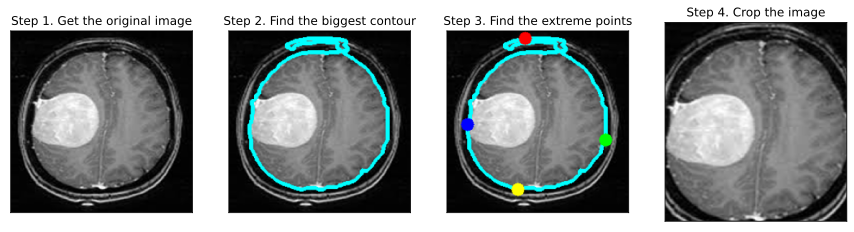

In [16]:
img = cv2.imread('yes/Y1.jpg')
IMG_SIZE = (224 , 224)
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()



plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [17]:
# Data Augmentation
transform = T.Compose([
    T.RandomRotation(15),                  # rotation_range=15
    T.RandomResizedCrop(224, scale=(0.95, 1.05)),  # width_shift_range and height_shift_range are combined
    T.RandomHorizontalFlip(),              # horizontal_flip=True
    T.RandomVerticalFlip(),                # vertical_flip=True
    T.ColorJitter(brightness=[0.1, 1.5]),  # brightness_range=[0.1, 1.5]
    T.ToTensor(),                          # rescale=1./255
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization values for pretrained models
])

In [18]:
def save_augmented_images(images, transform, save_dir, prefix, num_images=20):
    os.makedirs(save_dir, exist_ok=True)
    for i in range(num_images):
        for img in images:
            augmented_img = transform(img)
            # Convert back to PIL Image for saving
            pil_img = T.ToPILImage()(augmented_img)
            pil_img.save(os.path.join(save_dir, f"{prefix}_{i}.jpg"))

# Create a directory to save augmented images
os.mkdir('preview')

# Example image from X_train_crop (assuming it's a list of images in tensor form)
x = X_train_crop[0]  
# Convert the tensor to PIL Image
x_pil = T.ToPILImage()(x)

# Save augmented images
save_augmented_images([x_pil], transform, 'preview', 'aug_img', num_images=20)

FileExistsError: [Errno 17] File exists: 'preview'

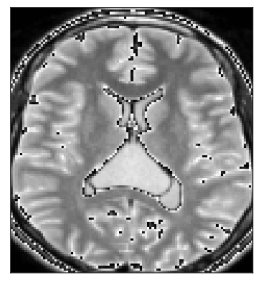

In [60]:
def show_image(img):
    # Check if the image is a tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy()  # Convert to NumPy array

    # If the image has three channels, ensure it's in HWC format
    if img.shape[0] in [1, 3]:  # If it has channels
        img = np.transpose(img, (1, 2, 0))  # Convert CHW to HWC format
    
    # If the image is normalized to [0, 1], scale it to [0, 255]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    # Display the image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Example usage
show_image(X_train_crop[0])

In [19]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'


train_transforms = T.Compose([
    T.RandomRotation(15),                  # rotation_range=15
    T.RandomResizedCrop(224, scale=(0.95, 1.05)),  # width_shift_range and height_shift_range are combined
    T.RandomHorizontalFlip(),              # horizontal_flip=True
    T.RandomVerticalFlip(),                # vertical_flip=True
    T.ColorJitter(brightness=[0.1, 1.5]),  # brightness_range=[0.1, 1.5]
    T.ToTensor(),                          # rescale=1./255
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization values for pretrained models
])

test_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [20]:
vggnet = torchvision.models.vgg16(pretrained=True)

/home/pratham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pratham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
vggnet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(vggnet.classifier[0].in_features, 1),
    nn.Sigmoid()
)

# Freeze the convolutional base layers
for param in vggnet.features.parameters():
    param.requires_grad = False

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vggnet = vggnet.to(device)

# Set up the loss function and optimizer



In [22]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.RMSprop(vggnet.classifier.parameters(), lr=1e-4)

In [67]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.RMSprop(vggnet.parameters(), lr=1e-4)

numepochs = 30
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epoch in range(numepochs):
    # Training phase
    vggnet.train()
    batchLoss = []
    batchAcc = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device).float()  # Ensure target is float

        optimizer.zero_grad()
        yHat = vggnet(X)
        loss = criterion(yHat, y.unsqueeze(1))  # Ensure output and target shapes match
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        
        # Compute accuracy
        yHat_prob = torch.sigmoid(yHat)  # Convert logits to probabilities
        predictions = (yHat_prob > 0.5).float()  # Convert probabilities to binary predictions
        accuracy = torch.mean((predictions == y.unsqueeze(1)).float()).item()
        batchAcc.append(accuracy)

    trainLoss[epoch] = np.mean(batchLoss)
    trainAcc[epoch] = 100 * np.mean(batchAcc)

    # Evaluation phase
    vggnet.eval()
    batchLoss = []
    batchAcc = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device).float()  # Ensure target is float

            yHat = vggnet(X)
            loss = criterion(yHat, y.unsqueeze(1))  # Ensure output and target shapes match

            batchLoss.append(loss.item())
            
            # Compute accuracy
            yHat_prob = torch.sigmoid(yHat)  # Convert logits to probabilities
            predictions = (yHat_prob > 0.5).float()  # Convert probabilities to binary predictions
            accuracy = torch.mean((predictions == y.unsqueeze(1)).float()).item()
            batchAcc.append(accuracy)

    testLoss[epoch] = np.mean(batchLoss)
    testAcc[epoch] = 100 * np.mean(batchAcc)

    print(f'Finished epoch {epoch + 1}/{numepochs}. Test accuracy = {testAcc[epoch]:.2f}%')





vggnet.eval()
with torch.no_grad():
    outputs = vggnet(X_test)
    predictions = torch.argmax(outputs, axis=1)
y_test_np = y_test.cpu().numpy()
predictions_np = predictions.cpu().numpy()


ind_list = np.argwhere(y_test_np != predictions_np).flatten()

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    # Display some misclassified images
    num_images_to_show = min(len(ind_list), 16)  # Show up to 16 images
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images_to_show):
        idx = ind_list[i]
        
        # Extract image and labels
        img = X_test[idx].cpu().numpy().transpose((1, 2, 0))
        img = img - np.min(img)  # Undo normalization
        img = img / np.max(img)  # Normalize to [0, 1]
        
        true_label = y_test_np[idx]
        predicted_label = predictions_np[idx]
        
        # Plot the image
        axs[i].imshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f'Actual: {true_label}\nPredicted: {predicted_label}')

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

Finished epoch 1/30. Test accuracy = 61.81%
Finished epoch 2/30. Test accuracy = 61.81%
Finished epoch 3/30. Test accuracy = 61.81%
Finished epoch 4/30. Test accuracy = 61.81%
Finished epoch 5/30. Test accuracy = 61.81%
Finished epoch 6/30. Test accuracy = 61.81%
Finished epoch 7/30. Test accuracy = 61.81%
Finished epoch 8/30. Test accuracy = 61.81%
Finished epoch 9/30. Test accuracy = 61.81%
Finished epoch 10/30. Test accuracy = 61.81%
Finished epoch 11/30. Test accuracy = 61.81%
Finished epoch 12/30. Test accuracy = 61.81%
Finished epoch 13/30. Test accuracy = 61.81%
Finished epoch 14/30. Test accuracy = 61.81%
Finished epoch 15/30. Test accuracy = 61.81%
Finished epoch 16/30. Test accuracy = 61.81%
Finished epoch 17/30. Test accuracy = 61.81%
Finished epoch 18/30. Test accuracy = 61.81%
Finished epoch 19/30. Test accuracy = 61.81%
Finished epoch 20/30. Test accuracy = 61.81%
Finished epoch 21/30. Test accuracy = 61.81%
Finished epoch 22/30. Test accuracy = 61.81%
Finished epoch 23/3

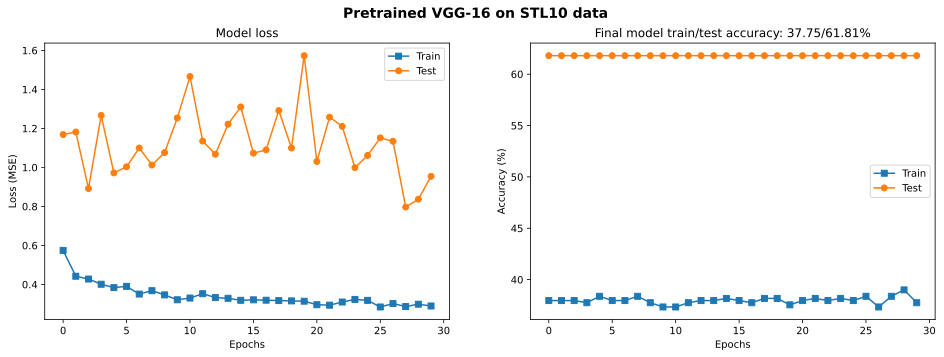

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()



torch.save(vggnet, '2019-06-07_VGG_model_complete.pth')
model = torch.load('2019-06-07_VGG_model_complete.pth')
model.eval()  # Set the model to evaluation mode






In [69]:
vggnet.eval()
with torch.no_grad():
    outputs = vggnet(X_test)
    predictions = torch.argmax(outputs, axis=1)
y_test_np = y_test.cpu().numpy()
predictions_np = predictions.cpu().numpy()


ind_list = np.argwhere(y_test_np != predictions_np).flatten()

if ind_list.size == 0:
    print('There are no misclassified images.')
else:
    # Display some misclassified images
    num_images_to_show = min(len(ind_list), 16)  # Show up to 16 images
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images_to_show):
        idx = ind_list[i]
        
        # Extract image and labels
        img = X_test[idx].cpu().numpy().transpose((1, 2, 0))
        img = img - np.min(img)  # Undo normalization
        img = img / np.max(img)  # Normalize to [0, 1]
        
        true_label = y_test_np[idx]
        predicted_label = predictions_np[idx]
        
        # Plot the image
        axs[i].imshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f'Actual: {true_label}\nPredicted: {predicted_label}')

    # Hide any unused subplots
    for j in range(num_images_to_show, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

NameError: name 'X_test' is not defined

In [ ]:
torch.save(vggnet, '2019-06-07_VGG_model_complete.pth')
model = torch.load('2019-06-07_VGG_model_complete.pth')
model.eval()  # Set the model to evaluation mode


In [26]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])






# Step 2: Load the image
image_path = 'example2.jpg'  # Replace with your image file path
image = Image.open(image_path)

if image.mode != 'RGB':
    image = image.convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

# Step 3: Inference
vggnet.eval()
with torch.no_grad():
    output = vggnet(image_tensor)

prediction = (output > 0.5).float()


# Step 4: Result Interpretation
if prediction.item() == 1:
    print("The model predicts: Tumor Present")
else:
    print("The model predicts: No Tumor")

The model predicts: Tumor Present
